# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [5]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = '/Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks'
file_container_obj = FileContainer(ROOT_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Select .bhv2/.h5 behavior file (i.e. 230927_Aragorn_choice.h5)
Behavior file selected: C:/Users/rober/SynologyDrive/Rob/gandalf_20231205/231205_Gandalf_UnityVR.h5
  MonkeyLogic Date: 231205
  MonkeyLogic Monkey: gandalf
Select directory containing White Matter video files (i.e. 230927_Aragorn)
Video files directory selected: C:/Users/rober/Desktop/rhAirpuff/videos/231205_Gandalf
  White Matter Video Date: 231205
  White Matter Video Monkey: gandalf
Select directory containing SpikeGLX files
SpikeGLX files directory selected: C:/Users/rober/SynologyDrive/Rob/gandalf_20231205/gandalf_20231205_g0
  SpikeGLX Date: 231205
  SpikeGLX Monkey: gandalf



***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [7]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 286
Parsing session data...


  0%|          | 0/286 [00:00<?, ?it/s]

  Complete.
    Correct trials: 176
    Errored trials: 110
    Session Length:  01:23:45
Creating Session Objects...
Lick threshold: 2.53 mV
Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...
   No novel fractal column found, skipping novel fractal...
   No fractal column found, skipping fractal count...


In [8]:
from config.add_fields import add_fields
# save is lick
# lick is photodiode
# photodiode is save
if session_obj.monkey == 'gandalf':
  session_obj.df['cam_save_2'] = session_obj.df['cam_save'].copy()
  session_obj.df['cam_sync_2'] = session_obj.df['cam_sync'].copy()
  session_obj.df['cam_sync'] = session_obj.df['lick'].copy() # correct
  session_obj.df['cam_save'] = session_obj.df['cam_sync_2'].copy()
  session_obj.df['lick'] = session_obj.df['cam_save_2'].copy()
  del session_obj.df['cam_sync_2']
  del session_obj.df['cam_save_2']

  session_obj.df, session_obj = \
  add_fields(session_obj.df, session_obj, behavioral_code_dict)

Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...
   No novel fractal column found, skipping novel fractal...
   No fractal column found, skipping fractal count...


In [9]:
session_obj.df.head()

,date,session_num,subject,trial_num,block,condition,correct,error,error_type,behavioral_code_markers,behavioral_code_times,eye_x,eye_y,eye_pupil,lick,cam_sync,cam_save,photodiode,trial_start,trial_end,trial_datetime_start,trial_datetime_end,Start trial,Frame skipped,Manual reward,End trial,Start,Reward,lick_raster,DEM_raster,trial_bins,trial_in_block,cam_frames
0,231205,0,gandalf,1,1,1,1,0,0,"[9, 10, 50, 18]","[3.4784000017680228, 2880.391000013333, 13314....","[-6.0667594861911125, -6.083853542221848, -6.1...","[7.3320901115399035, 7.328807233906357, 7.4433...","[8182.0, 8168.0, 8167.0, 8167.0, 8187.0, 8187....","[0.0062533447719864965, 0.0072398264486985275,...","[0.005266863094622737, 0.017104643180125986, 0...","[0.0049380358686898496, 0.007897480899478157, ...","[0.9210504981210056, 1.0252886962286676, 0.970...",0.0000,13663.0000,2023-12-05 17:00:52.262,2023-12-05 17:01:05.925,3,<NA>,<NA>,13660,2880,13314,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13662,0,"[754, 763, 771, 779, 788, 796, 804, 813, 821, ..."
1,231205,0,gandalf,2,1,1,0,1,6,"[9, 10, 18]","[343.97940000053495, 410.8777999645099, 17510....","[-0.9337724921111511, -0.994682550832626, -0.9...","[-10.835546183212456, -10.818512933477251, -10...","[6228.0, 6243.0, 6243.0, 6231.0, 6231.0, 6241....","[4.992267096038386, 5.0024607972454564, 4.9876...","[3.310967630531658, 3.3093234915896317, 3.3139...","[3.3267513646102476, 3.3162288751771523, 3.325...","[1.6089568759071933, 1.7533120117203995, 1.648...",13663.0518,31256.0518,2023-12-05 17:01:05.924,2023-12-05 17:01:23.517,343,<NA>,<NA>,17510,410,<NA>,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",17592,1,"[8, 16, 25, 33, 41, 50, 58, 66, 75, 83, 91, 10..."
2,231205,0,gandalf,3,1,1,0,1,6,"[9, 10, 18]","[201.48400001926348, 266.20070001808926, 10343...","[0.7700776784552404, 0.7700776784552404, 0.753...","[-10.275304116797535, -10.275304116797535, -10...","[5498.0, 5498.0, 5533.0, 5533.0, 5505.0, 5505....","[4.995226557647911, 4.994897728578924, 4.98601...","[3.3356297152173124, 3.313269425058244, 0.0049...","[3.3300396425970513, 3.334972059612135, 3.3356...","[2.059450167451071, 1.9982882963697595, 1.9262...",31255.5153,41680.5153,2023-12-05 17:01:23.517,2023-12-05 17:01:33.942,201,<NA>,<NA>,10343,266,<NA>,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",10424,2,"[7, 15, 23, 32, 40, 48, 57, 65, 73, 82, 90, 98..."
3,231205,0,gandalf,4,1,1,0,1,6,"[9, 10, 18]","[186.22759997379035, 249.8083999962546, 14063....","[0.37551485597474005, 0.40521379241456, 0.4052...","[-10.489857972433539, -10.499721066148492, -10...","[5648.0, 5638.0, 5638.0, 5619.0, 5619.0, 5644....","[4.995226557647911, 4.98601934383543, 4.992924...","[3.317544186345917, 3.316557702969066, 0.00132...","[3.323791914438004, 3.3389179932543875, 3.3228...","[2.056161894737025, 2.1798009549938904, 2.0525...",41679.7459,55825.7459,2023-12-05 17:01:33.941,2023-12-05 17:01:48.087,186,<NA>,<NA>,14063,249,<NA>,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",14146,3,"[7, 15, 23, 32, 40, 48, 57, 65, 73, 82, 90, 98..."
4,231205,0,gandalf,5,1,1,0,1,6,"[9, 10, 18]","[186.29480001982301, 265.30510000884533, 18832...","[6.4897034445916715, 6.4897034445916715, 6.452...","[-10.868593277922802, -10.868593277922802, -10...","[6090.0, 6090.0, 6062.0, 6062.0, 6049.0, 6049....","[0.008226308124759552, 0.012501062046851016, 0...","[0.008555135349968657, 0.003951554190456064, 3...","[3.325107225623812, 3.330697298196643, 3.32050...","[0.5264579420492492, 0.5205390534680839, 0.510...",55825.6678,74741.6678,2023-12-05 17:01:48.087,2023-12-05 17:02:07.003,186,<NA>,<NA>,18832,265,<NA>,"[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",18915,4,"[2, 11, 19, 27, 36, 44, 52, 61, 69, 77, 86, 94..."


In [70]:
import pickle
from config.h5_helper import pickler

pickler(True, os.path.dirname(file_container_obj.ml_file_path), 
        session_obj.df, 'gandalf', 'UnityVR', error_dict, behavioral_code_dict)

Saving .pickle files to: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff
  Pickling 231004_gandalf_UnityVR_behave.pkl
  Total time to pickle: 0.5141 sec


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [10]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start trial
  End trial


### Peek at SpikeGLX Analog Data
Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: C:\Users\rober\SynologyDrive\Rob\gandalf_20231205\gandalf_20231205_g0\gandalf_20231205_g0_t0.nidq.bin
File Name: D://saline_20231205_g0/saline_20231205_g0_t0.nidq.bin
  Number of Channels: 9
  File Created: 2023-12-05T17:00:46
  File Length: 5051.549966397743
nChan: 9, nFileSamp: 10103083
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  1999.996648
 Channel [0]: cam_sync
  Max Val: 3342.59
  Min Val: -6.104
 Channel [1]: cam_save
  Max Val: 3357.239
  Min Val: -8.24
 Channel [2]: lick
  Max Val: 5008.24
  Min Val: -30.823
 Channel [3]: photodiode
  Max Val: 2246.094
  Min Val: 398.254
 Channel [4]: empty
 Channel [5]: empty
 Channel [6]: empty
 Channel [7]: empty
 Channel [8]: empty


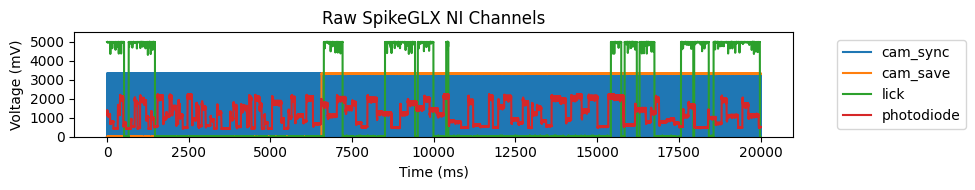

In [11]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=20)

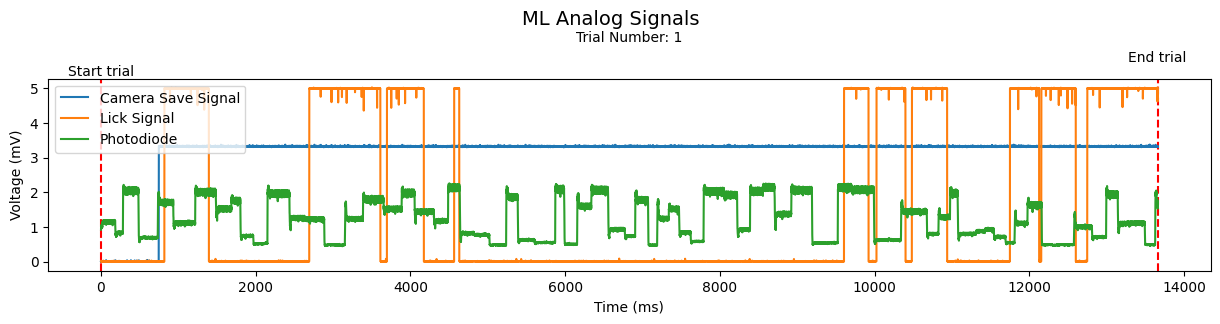

In [12]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

Created new session folder: c:\Users\rober\Desktop\Monkey-Emotions\_data\gandalf_231205
Pickled spikeglx_obj not found for: gandalf_231205
Generating new spikeglx_obj...
  Looking for SpikeGLX binary and meta file in:
  C:/Users/rober/SynologyDrive/Rob/gandalf_20231205
Looking for binary file in C:/Users/rober/SynologyDrive/Rob/gandalf_20231205
Found folder: gandalf_20231205_g0
  Found binary file: gandalf_20231205_g0_t0.nidq.bin
  Found metadata file: gandalf_20231205_g0_t0.nidq.meta
File Name: D://saline_20231205_g0/saline_20231205_g0_t0.nidq.bin
  Number of Channels: 9
  File Created: 2023-12-05T17:00:46
  File Length: 5051.549966397743
nChan: 9, nFileSamp: 10103083
Number of Channels:  9
Sample Rate:  1999.996648
Number of frames in SpikeGLX Cam TTL: 603016


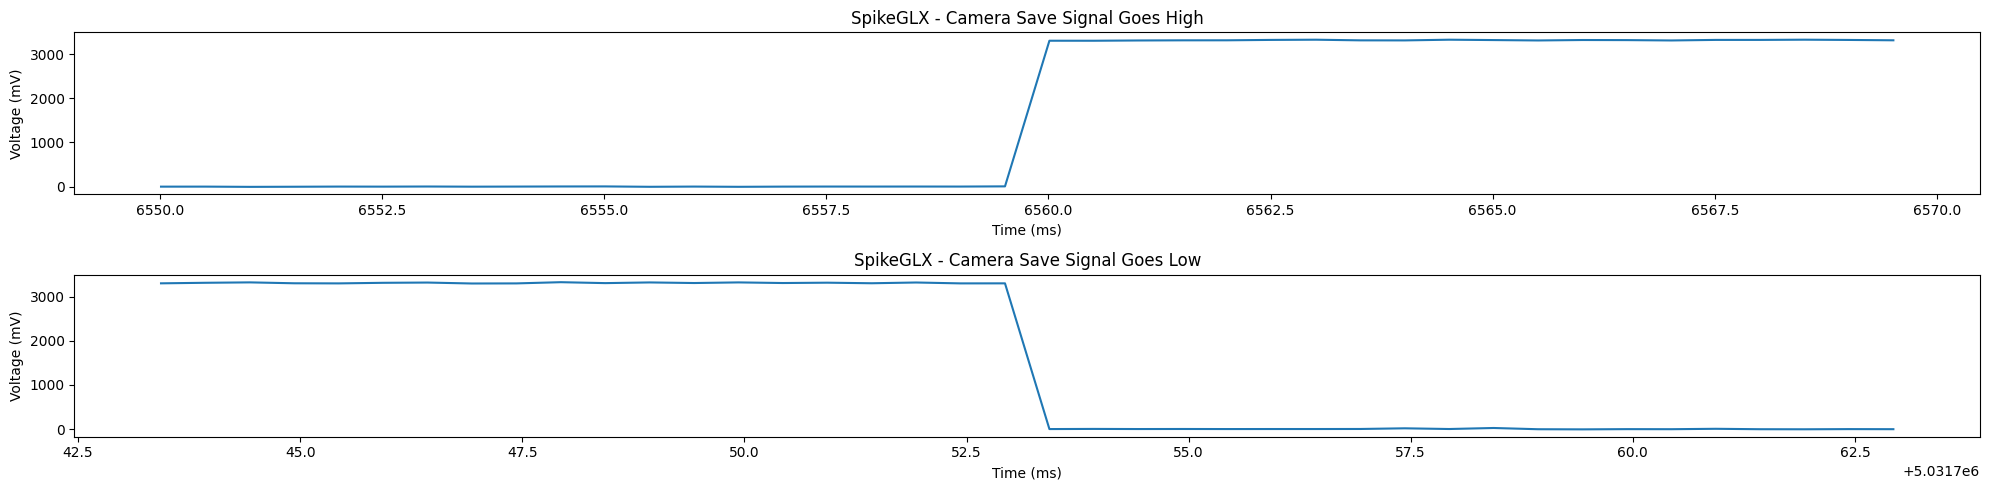

Video Folders:
['231205_Gandalf_170052', '231205_Gandalf_170317', '231205_Gandalf_173109']
Number of cameras: 4
  Camera: e3v831b | Number of videos: 5
  Camera: e3v8360 | Number of videos: 5
  Camera: e3v83ad | Number of videos: 5
  Camera: e3v83d6 | Number of videos: 5
Camera: e3v831b
  Video: e3v831b-20231205T170053-172054.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231205T172054-174054.avi | Frames: 144005 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231205T174054-180054.avi | Frames: 144004 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20231205T180054-182055.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20231205T182055-182438.avi | Frames: 26762  | FPS: 120.0 | Length (minutes): 3.72   
  Total Frames: 603017
Camera: e3v8360
  Video: e3v8360-20231205T170053-172054.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v8360-20231205T172054-174054.avi | Frames: 144005 

Trial Number:   0%|          | 0/285 [00:00<?, ?it/s]

Trial 1 | Correlation: 0.992 | SGLX High Time: 13120 | ML High Time: 747
  Trial 1 | Epoch start 5813.010994578427 | Epoch end 19476.010994578428
Trial 2 low on first approximation | Correlation: -0.167 | SGLX High Time: 2 | ML High Time: 159
  Photodiode aligned. Correlation: 0.984 | Shift: -2
  Trial 2 | Epoch start 19474.010994578428 | Epoch end 37067.01099457843
Trial 3 low on first approximation | Correlation: 0.0 | SGLX High Time: 1746 | ML High Time: 257
  Photodiode aligned. Correlation: 0.984 | Shift: 1
  Trial 3 | Epoch start 37068.01099457843 | Epoch end 47493.01099457843
Trial 4 low on first approximation | Correlation: -0.129 | SGLX High Time: 144 | ML High Time: 230
  Photodiode aligned. Correlation: 0.983 | Shift: 0
  Trial 4 | Epoch start 47493.01099457843 | Epoch end 61639.01099457843
Trial 5 low on first approximation | Correlation: -0.049 | SGLX High Time: 11 | ML High Time: 287
  Photodiode aligned. Correlation: 0.982 | Shift: 0
  Trial 5 | Epoch start 61639.0109945

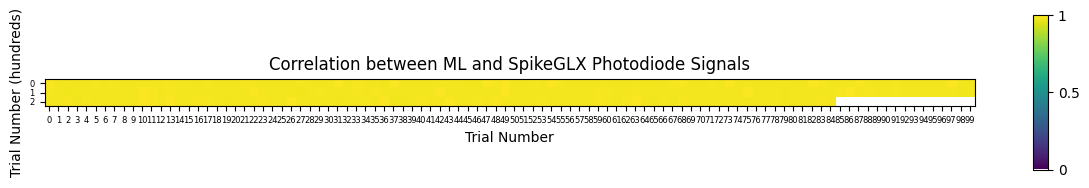

  Done.
Comparing ML and SpikeGLX photodiode signals...
Number of frames in ML Cam TTL: 602941
Number of frames in SpikeGLX Cam TTL: 603016
  Done.
Plotting ML and SpikeGLX photodiode signals...


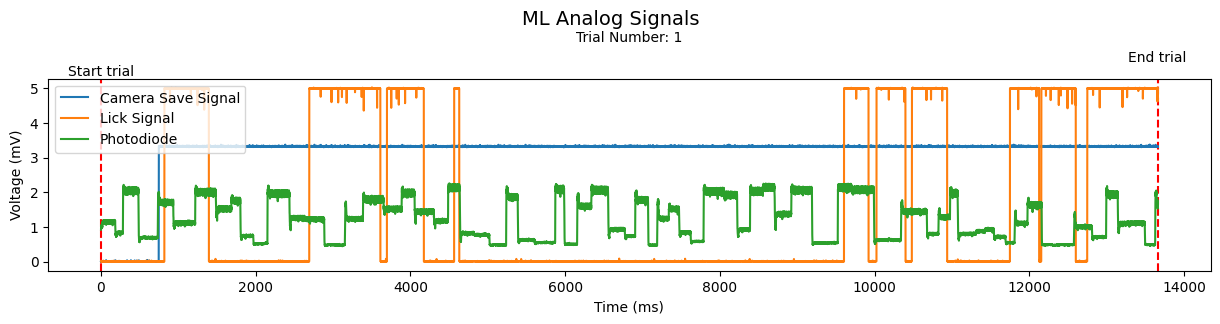

  Done.
Plotting first trial...


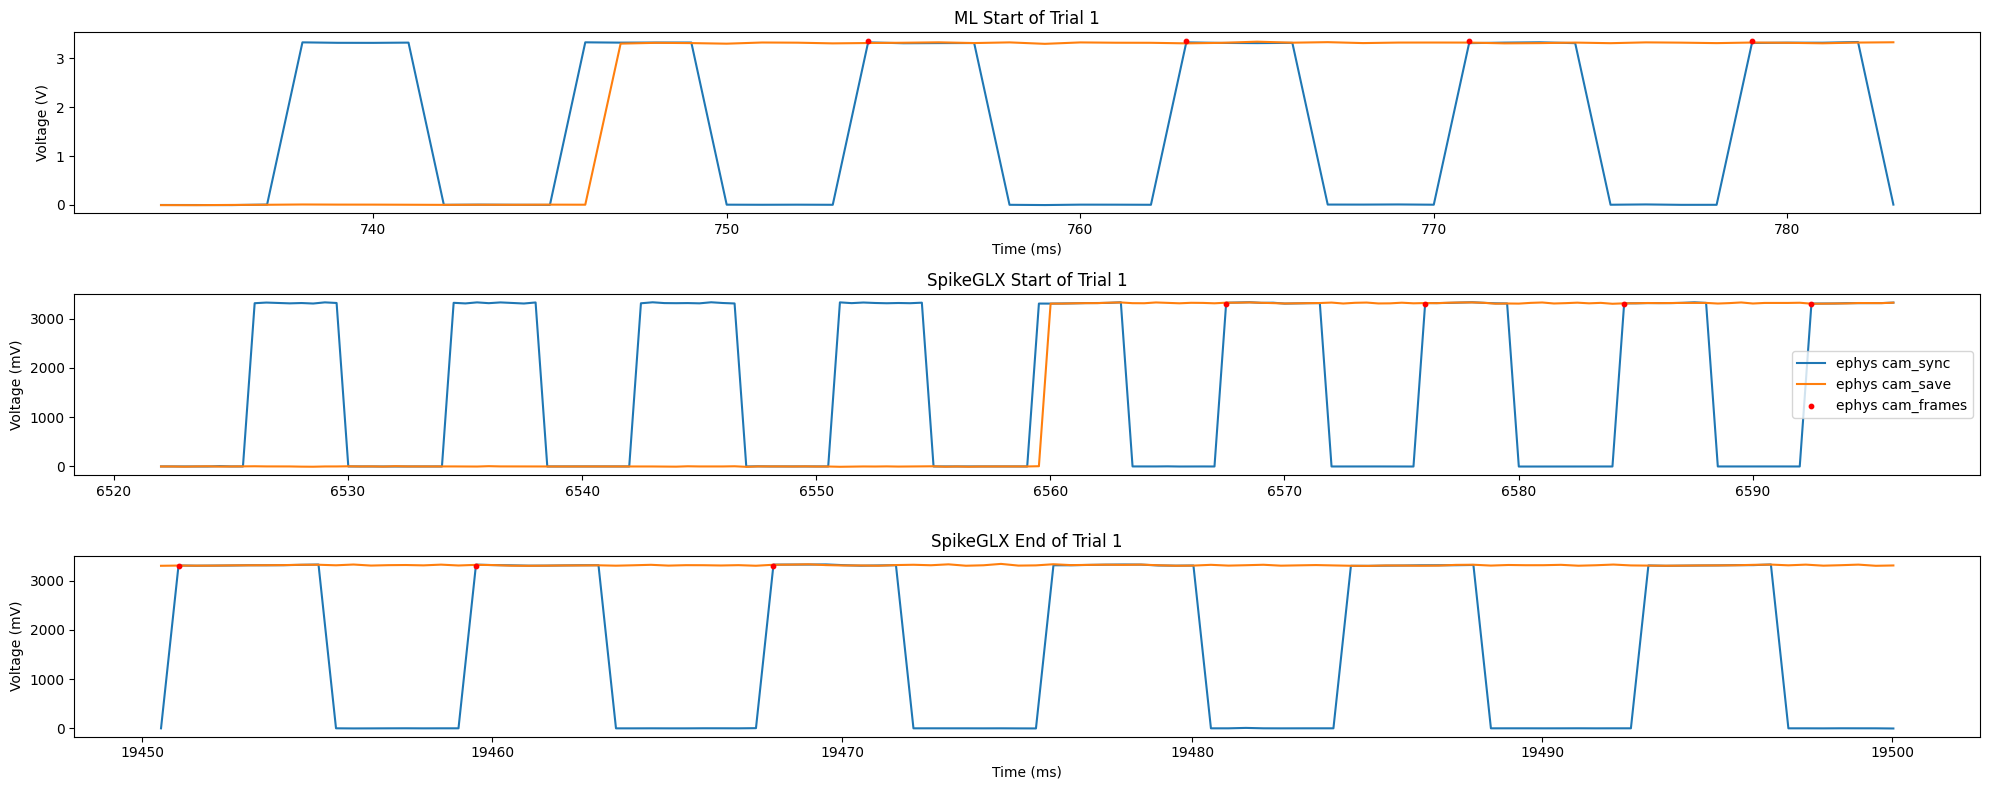

  Done.
Saving spikeglx_obj...
  Pickle file size: 408.994381 MB
  Pickle file path: _data\gandalf_231205\spikeglx_obj_gandalf_231205.pkl
Done. Saved spikeglx_obj.


In [13]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

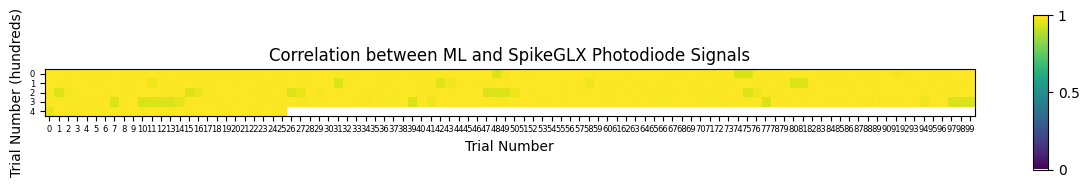

In [10]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [14]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 0,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False}               # 'thread_flag': False

parse_wm_videos(**kwargs)

Video Parsing Complete.
  Missing Videos: defaultdict(<class 'list'>, {'e3v831b': [74, 135, 214, 281], 'e3v8360': [74, 135, 214, 281], 'e3v83ad': [74, 135, 214, 281], 'e3v83d6': [74, 135, 214, 281]})


***
## DeepLabCut

In [15]:
import deeplabcut

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

Loading DLC 2.3.7...


In [16]:
from dlc_primate.dlc_utils import dlc_config, dlc_downsample
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205


  0%|          | 0/1124 [00:00<?, ?it/s]

  Camera: e3v831b | Number of videos: 281
  Camera: e3v8360 | Number of videos: 281
  Camera: e3v83ad | Number of videos: 281
  Camera: e3v83d6 | Number of videos: 281


In [17]:
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

# Initialize Project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)

Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_2
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\gandalf_231205\\gandalf_231205_0_e3v831b.mp4']
Created "231205_gandalf\body_2-rh-2023-12-06\videos"
Created "231205_gandalf\body_2-rh-2023-12-06\labeled-data"
Created "231205_gandalf\body_2-rh-2023-12-06\training-datasets"
Created "231205_gandalf\body_2-rh-2023-12-06\dlc-models"
Copying the videos
231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_0_e3v831b.mp4
Generated "231205_gandalf\body_2-rh-2023-12-06\config.yaml"

A new project with name body_2-rh-2023-12-06 is created at 231205_gandalf and a configurable file (config.yaml) is stored there. Change the parameters in this file to adapt to your project's needs.
 Once you have changed the configuration file, use the function 'extract_frames' to select frames for labeling.
. [OPTIONAL] Use the functi

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_2-rh-2023-12-06\dlc-models\iteration-0\body_2Dec6-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


231205_gandalf\body_2-rh-2023-12-06\dlc-models\iteration-0\body_2Dec6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model 231205_gandalf\body_2-rh-2023-12-06\dlc-models\iteration-0\body_2Dec6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_0_e3v831b.mp4
Loading  231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_0_e3v831b.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [05:41<00:00,  4.54it/s]


Saving results in 231205_gandalf\body_2-rh-2023-12-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_1
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\gandalf_231205\\gandalf_231205_0_e3v8360.mp4']
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\videos"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\labeled-data"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\training-datasets"
Created "C:\Users\rober\Desktop\Monkey-

(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\dlc-models\iteration-0\face_1Dec6-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\dlc-models\iteration-0\face_1Dec6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\dlc-models\iteration-0\face_1Dec6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\videos\gandalf_231205_0_e3v8360.mp4
Loading  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\videos\gandalf_231205_0_e3v8360.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [05:54<00:00,  4.37it/s]


Saving results in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_1-rh-2023-12-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: body_1
  Model: full_macaque
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\gandalf_231205\\gandalf_231205_0_e3v83ad.mp4']
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\videos"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\labeled-data"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12

DLC_macaque_full_resnet50.tar.gz:   0%|          | 0.00/182M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\dlc-models\iteration-0\body_1Dec6-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\dlc-models\iteration-0\body_1Dec6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\dlc-models\iteration-0\body_1Dec6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\videos\gandalf_231205_0_e3v83ad.mp4
Loading  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\videos\gandalf_231205_0_e3v83ad.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [05:39<00:00,  4.55it/s]


Saving results in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\body_1-rh-2023-12-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: face_2
  Model: primate_face
  Initilization Videos: ['c:\\Users\\rober\\Desktop\\Monkey-Emotions\\video\\gandalf_231205\\gandalf_231205_0_e3v83d6.mp4']
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\videos"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\labeled-data"
Created "C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\training-datasets"


(…)e_resnet_50_iteration-1_shuffle-1.tar.gz:   0%|          | 0.00/198M [00:00<?, ?B/s]

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\huggingface_hub\file_download.py:138: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\dlc-models\iteration-0\face_2Dec6-trainset95shuffle1\train. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\dlc-models\iteration-0\face_2Dec6-trainset95shuffle1\train\pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\dlc-models\iteration-0\face_2Dec6-trainset95shuffle1


c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\videos\gandalf_231205_0_e3v83d6.mp4
Loading  C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\videos\gandalf_231205_0_e3v83d6.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [06:01<00:00,  4.29it/s]


Saving results in C:\Users\rober\Desktop\Monkey-Emotions\231205_gandalf\face_2-rh-2023-12-06\videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
  Editing config file.


In [18]:
# Run DLC
dlc_config.dlc_run(config_path_dict, dlc_video_path_dict, 
                   start_video=0, end_video=None, videotype='mp4')

Attempting to create a symbolic link of the video ...
Video 231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_0_e3v831b.mp4 already exists. Skipping...
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_1_e3v831b.mp4 copied to 231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_1_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_2_e3v831b.mp4 copied to 231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_2_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_3_e3v831b.mp4 copied to 231205_gandalf\body_2-rh-2023-12-06\videos\gandalf_231205_3_e3v831b.mp4
Symlink creation impossible (exFat architecture?): copying the video instead.
c:\Users\rober\

c:\Users\rober\anaconda3\envs\DEEPLABCUT\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_0_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_0_e3v831b.mp4
Duration of video [s]:  12.9 , recorded with  120.0 fps!
Overall # of frames:  1548  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1548/1548 [05:32<00:00,  4.65it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_1_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_1_e3v831b.mp4
Duration of video [s]:  17.58 , recorded with  120.0 fps!
Overall # of frames:  2110  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2110/2110 [07:31<00:00,  4.68it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_2_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_2_e3v831b.mp4
Duration of video [s]:  10.42 , recorded with  120.0 fps!
Overall # of frames:  1250  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1250/1250 [04:38<00:00,  4.49it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_3_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_3_e3v831b.mp4
Duration of video [s]:  14.14 , recorded with  120.0 fps!
Overall # of frames:  1697  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1697/1697 [06:16<00:00,  4.51it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_4_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_4_e3v831b.mp4
Duration of video [s]:  18.91 , recorded with  120.0 fps!
Overall # of frames:  2269  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2269/2269 [08:21<00:00,  4.52it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_5_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_5_e3v831b.mp4
Duration of video [s]:  14.57 , recorded with  120.0 fps!
Overall # of frames:  1748  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1748/1748 [06:15<00:00,  4.65it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_6_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_6_e3v831b.mp4
Duration of video [s]:  13.63 , recorded with  120.0 fps!
Overall # of frames:  1636  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1636/1636 [05:55<00:00,  4.60it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_7_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_7_e3v831b.mp4
Duration of video [s]:  14.64 , recorded with  120.0 fps!
Overall # of frames:  1757  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1757/1757 [06:27<00:00,  4.53it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_8_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_8_e3v831b.mp4
Duration of video [s]:  12.17 , recorded with  120.0 fps!
Overall # of frames:  1460  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1460/1460 [05:12<00:00,  4.68it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_9_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_9_e3v831b.mp4
Duration of video [s]:  14.92 , recorded with  120.0 fps!
Overall # of frames:  1790  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1790/1790 [06:33<00:00,  4.54it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_10_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_10_e3v831b.mp4
Duration of video [s]:  13.74 , recorded with  120.0 fps!
Overall # of frames:  1649  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1649/1649 [06:02<00:00,  4.55it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_11_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_11_e3v831b.mp4
Duration of video [s]:  13.25 , recorded with  120.0 fps!
Overall # of frames:  1590  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1590/1590 [05:48<00:00,  4.57it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_12_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_12_e3v831b.mp4
Duration of video [s]:  15.69 , recorded with  120.0 fps!
Overall # of frames:  1883  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1883/1883 [06:52<00:00,  4.56it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_13_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_13_e3v831b.mp4
Duration of video [s]:  10.85 , recorded with  120.0 fps!
Overall # of frames:  1302  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1302/1302 [04:43<00:00,  4.60it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_14_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_14_e3v831b.mp4
Duration of video [s]:  25.43 , recorded with  120.0 fps!
Overall # of frames:  3051  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3051/3051 [11:05<00:00,  4.59it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_15_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_15_e3v831b.mp4
Duration of video [s]:  16.51 , recorded with  120.0 fps!
Overall # of frames:  1981  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1981/1981 [07:06<00:00,  4.65it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_16_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_16_e3v831b.mp4
Duration of video [s]:  11.82 , recorded with  120.0 fps!
Overall # of frames:  1418  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1418/1418 [05:06<00:00,  4.63it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_17_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_17_e3v831b.mp4
Duration of video [s]:  15.74 , recorded with  120.0 fps!
Overall # of frames:  1889  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1889/1889 [06:45<00:00,  4.66it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_18_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_18_e3v831b.mp4
Duration of video [s]:  18.37 , recorded with  120.0 fps!
Overall # of frames:  2204  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2204/2204 [07:55<00:00,  4.63it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_19_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_19_e3v831b.mp4
Duration of video [s]:  15.28 , recorded with  120.0 fps!
Overall # of frames:  1833  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1833/1833 [06:35<00:00,  4.63it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_20_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_20_e3v831b.mp4
Duration of video [s]:  12.32 , recorded with  120.0 fps!
Overall # of frames:  1478  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1478/1478 [05:18<00:00,  4.64it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_21_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_21_e3v831b.mp4
Duration of video [s]:  15.44 , recorded with  120.0 fps!
Overall # of frames:  1853  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1853/1853 [06:08<00:00,  5.03it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_22_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_22_e3v831b.mp4
Duration of video [s]:  12.72 , recorded with  120.0 fps!
Overall # of frames:  1526  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1526/1526 [04:56<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_23_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_23_e3v831b.mp4
Duration of video [s]:  17.68 , recorded with  120.0 fps!
Overall # of frames:  2121  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2121/2121 [06:54<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_24_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_24_e3v831b.mp4
Duration of video [s]:  18.22 , recorded with  120.0 fps!
Overall # of frames:  2186  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2186/2186 [07:05<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_25_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_25_e3v831b.mp4
Duration of video [s]:  13.04 , recorded with  120.0 fps!
Overall # of frames:  1565  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1565/1565 [05:06<00:00,  5.10it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_26_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_26_e3v831b.mp4
Duration of video [s]:  12.77 , recorded with  120.0 fps!
Overall # of frames:  1532  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1532/1532 [04:58<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_27_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_27_e3v831b.mp4
Duration of video [s]:  15.04 , recorded with  120.0 fps!
Overall # of frames:  1805  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1805/1805 [05:51<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_28_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_28_e3v831b.mp4
Duration of video [s]:  12.39 , recorded with  120.0 fps!
Overall # of frames:  1487  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1487/1487 [04:49<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_29_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_29_e3v831b.mp4
Duration of video [s]:  13.38 , recorded with  120.0 fps!
Overall # of frames:  1606  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1606/1606 [05:13<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_30_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_30_e3v831b.mp4
Duration of video [s]:  16.61 , recorded with  120.0 fps!
Overall # of frames:  1993  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1993/1993 [06:28<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_31_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_31_e3v831b.mp4
Duration of video [s]:  16.1 , recorded with  120.0 fps!
Overall # of frames:  1932  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1932/1932 [06:16<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_32_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_32_e3v831b.mp4
Duration of video [s]:  12.22 , recorded with  120.0 fps!
Overall # of frames:  1467  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1467/1467 [04:46<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_33_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_33_e3v831b.mp4
Duration of video [s]:  14.82 , recorded with  120.0 fps!
Overall # of frames:  1778  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1778/1778 [05:46<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_34_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_34_e3v831b.mp4
Duration of video [s]:  18.98 , recorded with  120.0 fps!
Overall # of frames:  2277  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2277/2277 [07:22<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_35_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_35_e3v831b.mp4
Duration of video [s]:  10.13 , recorded with  120.0 fps!
Overall # of frames:  1216  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1216/1216 [03:58<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_36_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_36_e3v831b.mp4
Duration of video [s]:  12.55 , recorded with  120.0 fps!
Overall # of frames:  1506  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1506/1506 [04:54<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_37_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_37_e3v831b.mp4
Duration of video [s]:  17.94 , recorded with  120.0 fps!
Overall # of frames:  2153  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2153/2153 [07:01<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_38_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_38_e3v831b.mp4
Duration of video [s]:  17.37 , recorded with  120.0 fps!
Overall # of frames:  2084  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2084/2084 [06:45<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_39_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_39_e3v831b.mp4
Duration of video [s]:  14.71 , recorded with  120.0 fps!
Overall # of frames:  1765  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1765/1765 [05:44<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_40_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_40_e3v831b.mp4
Duration of video [s]:  11.6 , recorded with  120.0 fps!
Overall # of frames:  1392  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1392/1392 [04:30<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_41_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_41_e3v831b.mp4
Duration of video [s]:  45.07 , recorded with  120.0 fps!
Overall # of frames:  5408  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 5408/5408 [17:32<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_42_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_42_e3v831b.mp4
Duration of video [s]:  17.65 , recorded with  120.0 fps!
Overall # of frames:  2118  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2118/2118 [06:59<00:00,  5.05it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_43_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_43_e3v831b.mp4
Duration of video [s]:  15.41 , recorded with  120.0 fps!
Overall # of frames:  1849  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1849/1849 [06:01<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_44_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_44_e3v831b.mp4
Duration of video [s]:  15.68 , recorded with  120.0 fps!
Overall # of frames:  1882  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1882/1882 [06:08<00:00,  5.10it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_45_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_45_e3v831b.mp4
Duration of video [s]:  17.57 , recorded with  120.0 fps!
Overall # of frames:  2109  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2109/2109 [06:46<00:00,  5.19it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_46_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_46_e3v831b.mp4
Duration of video [s]:  16.04 , recorded with  120.0 fps!
Overall # of frames:  1925  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1925/1925 [06:13<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_47_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_47_e3v831b.mp4
Duration of video [s]:  16.45 , recorded with  120.0 fps!
Overall # of frames:  1974  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1974/1974 [06:23<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_48_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_48_e3v831b.mp4
Duration of video [s]:  15.71 , recorded with  120.0 fps!
Overall # of frames:  1885  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1885/1885 [06:06<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_49_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_49_e3v831b.mp4
Duration of video [s]:  15.36 , recorded with  120.0 fps!
Overall # of frames:  1843  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1843/1843 [05:58<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_50_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_50_e3v831b.mp4
Duration of video [s]:  16.27 , recorded with  120.0 fps!
Overall # of frames:  1953  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1953/1953 [06:19<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_51_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_51_e3v831b.mp4
Duration of video [s]:  14.18 , recorded with  120.0 fps!
Overall # of frames:  1702  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1702/1702 [05:30<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_52_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_52_e3v831b.mp4
Duration of video [s]:  12.0 , recorded with  120.0 fps!
Overall # of frames:  1440  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1440/1440 [04:39<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_53_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_53_e3v831b.mp4
Duration of video [s]:  15.91 , recorded with  120.0 fps!
Overall # of frames:  1909  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1909/1909 [06:10<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_54_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_54_e3v831b.mp4
Duration of video [s]:  14.89 , recorded with  120.0 fps!
Overall # of frames:  1787  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1787/1787 [05:49<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_55_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_55_e3v831b.mp4
Duration of video [s]:  10.08 , recorded with  120.0 fps!
Overall # of frames:  1210  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1210/1210 [03:55<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_56_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_56_e3v831b.mp4
Duration of video [s]:  16.57 , recorded with  120.0 fps!
Overall # of frames:  1988  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1988/1988 [06:25<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_57_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_57_e3v831b.mp4
Duration of video [s]:  16.41 , recorded with  120.0 fps!
Overall # of frames:  1969  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1969/1969 [06:22<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_58_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_58_e3v831b.mp4
Duration of video [s]:  18.24 , recorded with  120.0 fps!
Overall # of frames:  2189  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2189/2189 [07:04<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_59_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_59_e3v831b.mp4
Duration of video [s]:  10.48 , recorded with  120.0 fps!
Overall # of frames:  1258  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1258/1258 [04:04<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_60_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_60_e3v831b.mp4
Duration of video [s]:  20.92 , recorded with  120.0 fps!
Overall # of frames:  2510  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2510/2510 [08:07<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_61_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_61_e3v831b.mp4
Duration of video [s]:  14.88 , recorded with  120.0 fps!
Overall # of frames:  1786  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1786/1786 [05:47<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_62_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_62_e3v831b.mp4
Duration of video [s]:  19.56 , recorded with  120.0 fps!
Overall # of frames:  2347  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2347/2347 [07:35<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_63_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_63_e3v831b.mp4
Duration of video [s]:  14.64 , recorded with  120.0 fps!
Overall # of frames:  1757  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1757/1757 [05:41<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_64_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_64_e3v831b.mp4
Duration of video [s]:  19.32 , recorded with  120.0 fps!
Overall # of frames:  2318  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2318/2318 [07:31<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_65_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_65_e3v831b.mp4
Duration of video [s]:  17.73 , recorded with  120.0 fps!
Overall # of frames:  2127  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2127/2127 [06:52<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_66_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_66_e3v831b.mp4
Duration of video [s]:  11.98 , recorded with  120.0 fps!
Overall # of frames:  1438  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1438/1438 [04:39<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_67_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_67_e3v831b.mp4
Duration of video [s]:  16.17 , recorded with  120.0 fps!
Overall # of frames:  1940  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1940/1940 [06:16<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_68_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_68_e3v831b.mp4
Duration of video [s]:  11.1 , recorded with  120.0 fps!
Overall # of frames:  1332  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1332/1332 [04:19<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_69_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_69_e3v831b.mp4
Duration of video [s]:  16.93 , recorded with  120.0 fps!
Overall # of frames:  2031  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2031/2031 [06:34<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_70_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_70_e3v831b.mp4
Duration of video [s]:  15.73 , recorded with  120.0 fps!
Overall # of frames:  1888  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1888/1888 [06:03<00:00,  5.20it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_71_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_71_e3v831b.mp4
Duration of video [s]:  51.2 , recorded with  120.0 fps!
Overall # of frames:  6144  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6144/6144 [20:00<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_72_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_72_e3v831b.mp4
Duration of video [s]:  27.27 , recorded with  120.0 fps!
Overall # of frames:  3272  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 3272/3272 [10:47<00:00,  5.05it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_73_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_73_e3v831b.mp4
Duration of video [s]:  14.55 , recorded with  120.0 fps!
Overall # of frames:  1746  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1746/1746 [05:39<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_75_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_75_e3v831b.mp4
Duration of video [s]:  12.92 , recorded with  120.0 fps!
Overall # of frames:  1550  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1550/1550 [05:00<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_76_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_76_e3v831b.mp4
Duration of video [s]:  16.71 , recorded with  120.0 fps!
Overall # of frames:  2005  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2005/2005 [06:29<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_77_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_77_e3v831b.mp4
Duration of video [s]:  17.4 , recorded with  120.0 fps!
Overall # of frames:  2088  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2088/2088 [06:45<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_78_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_78_e3v831b.mp4
Duration of video [s]:  18.62 , recorded with  120.0 fps!
Overall # of frames:  2234  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2234/2234 [07:15<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_79_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_79_e3v831b.mp4
Duration of video [s]:  11.15 , recorded with  120.0 fps!
Overall # of frames:  1338  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1338/1338 [04:20<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_80_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_80_e3v831b.mp4
Duration of video [s]:  9.47 , recorded with  120.0 fps!
Overall # of frames:  1136  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1136/1136 [03:41<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_81_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_81_e3v831b.mp4
Duration of video [s]:  14.44 , recorded with  120.0 fps!
Overall # of frames:  1733  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1733/1733 [05:36<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_82_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_82_e3v831b.mp4
Duration of video [s]:  15.78 , recorded with  120.0 fps!
Overall # of frames:  1893  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1893/1893 [06:10<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_83_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_83_e3v831b.mp4
Duration of video [s]:  14.49 , recorded with  120.0 fps!
Overall # of frames:  1739  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1739/1739 [05:38<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_84_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_84_e3v831b.mp4
Duration of video [s]:  15.07 , recorded with  120.0 fps!
Overall # of frames:  1809  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1809/1809 [05:53<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_85_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_85_e3v831b.mp4
Duration of video [s]:  18.66 , recorded with  120.0 fps!
Overall # of frames:  2239  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2239/2239 [07:15<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_86_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_86_e3v831b.mp4
Duration of video [s]:  14.91 , recorded with  120.0 fps!
Overall # of frames:  1789  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1789/1789 [05:47<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_87_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_87_e3v831b.mp4
Duration of video [s]:  21.98 , recorded with  120.0 fps!
Overall # of frames:  2637  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2637/2637 [08:30<00:00,  5.17it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_88_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_88_e3v831b.mp4
Duration of video [s]:  14.98 , recorded with  120.0 fps!
Overall # of frames:  1798  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1798/1798 [05:48<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_89_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_89_e3v831b.mp4
Duration of video [s]:  14.57 , recorded with  120.0 fps!
Overall # of frames:  1748  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1748/1748 [05:39<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_90_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_90_e3v831b.mp4
Duration of video [s]:  11.75 , recorded with  120.0 fps!
Overall # of frames:  1410  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1410/1410 [04:34<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_91_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_91_e3v831b.mp4
Duration of video [s]:  50.73 , recorded with  120.0 fps!
Overall # of frames:  6088  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6088/6088 [19:44<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_92_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_92_e3v831b.mp4
Duration of video [s]:  46.36 , recorded with  120.0 fps!
Overall # of frames:  5563  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 5563/5563 [17:58<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_93_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_93_e3v831b.mp4
Duration of video [s]:  14.84 , recorded with  120.0 fps!
Overall # of frames:  1781  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1781/1781 [05:46<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_94_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_94_e3v831b.mp4
Duration of video [s]:  13.83 , recorded with  120.0 fps!
Overall # of frames:  1660  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1660/1660 [05:23<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_95_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_95_e3v831b.mp4
Duration of video [s]:  14.85 , recorded with  120.0 fps!
Overall # of frames:  1782  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1782/1782 [05:47<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_96_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_96_e3v831b.mp4
Duration of video [s]:  15.21 , recorded with  120.0 fps!
Overall # of frames:  1825  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1825/1825 [05:56<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_97_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_97_e3v831b.mp4
Duration of video [s]:  17.49 , recorded with  120.0 fps!
Overall # of frames:  2099  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2099/2099 [06:50<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_98_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_98_e3v831b.mp4
Duration of video [s]:  15.53 , recorded with  120.0 fps!
Overall # of frames:  1864  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1864/1864 [06:02<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_99_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_99_e3v831b.mp4
Duration of video [s]:  16.98 , recorded with  120.0 fps!
Overall # of frames:  2037  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2037/2037 [06:36<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_100_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_100_e3v831b.mp4
Duration of video [s]:  10.97 , recorded with  120.0 fps!
Overall # of frames:  1316  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1316/1316 [04:17<00:00,  5.10it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_101_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_101_e3v831b.mp4
Duration of video [s]:  18.77 , recorded with  120.0 fps!
Overall # of frames:  2253  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2253/2253 [07:24<00:00,  5.06it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_102_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_102_e3v831b.mp4
Duration of video [s]:  13.08 , recorded with  120.0 fps!
Overall # of frames:  1570  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1570/1570 [05:06<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_103_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_103_e3v831b.mp4
Duration of video [s]:  13.87 , recorded with  120.0 fps!
Overall # of frames:  1664  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1664/1664 [05:23<00:00,  5.14it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_104_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_104_e3v831b.mp4
Duration of video [s]:  16.52 , recorded with  120.0 fps!
Overall # of frames:  1983  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1983/1983 [06:26<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_105_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_105_e3v831b.mp4
Duration of video [s]:  20.24 , recorded with  120.0 fps!
Overall # of frames:  2429  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2429/2429 [07:53<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_106_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_106_e3v831b.mp4
Duration of video [s]:  17.76 , recorded with  120.0 fps!
Overall # of frames:  2131  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2131/2131 [06:55<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_107_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_107_e3v831b.mp4
Duration of video [s]:  12.0 , recorded with  120.0 fps!
Overall # of frames:  1440  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1440/1440 [04:41<00:00,  5.11it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_108_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_108_e3v831b.mp4
Duration of video [s]:  16.04 , recorded with  120.0 fps!
Overall # of frames:  1925  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1925/1925 [06:15<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_109_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_109_e3v831b.mp4
Duration of video [s]:  15.6 , recorded with  120.0 fps!
Overall # of frames:  1872  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1872/1872 [06:03<00:00,  5.15it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_110_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_110_e3v831b.mp4
Duration of video [s]:  21.24 , recorded with  120.0 fps!
Overall # of frames:  2549  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2549/2549 [08:17<00:00,  5.12it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_111_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_111_e3v831b.mp4
Duration of video [s]:  51.55 , recorded with  120.0 fps!
Overall # of frames:  6186  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 6186/6186 [20:06<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_112_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_112_e3v831b.mp4
Duration of video [s]:  18.05 , recorded with  120.0 fps!
Overall # of frames:  2166  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 2166/2166 [07:02<00:00,  5.13it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_113_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_113_e3v831b.mp4
Duration of video [s]:  15.09 , recorded with  120.0 fps!
Overall # of frames:  1811  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 1811/1811 [05:50<00:00,  5.16it/s]


Saving results in c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205...
Saving csv poses!
Starting to analyze %  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_114_e3v831b.mp4
Loading  c:\Users\rober\Desktop\Monkey-Emotions\video\gandalf_231205\gandalf_231205_114_e3v831b.mp4
Duration of video [s]:  51.2 , recorded with  120.0 fps!
Overall # of frames:  6144  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


 88%|████████▊ | 5384/6144 [17:25<02:34,  4.91it/s]

***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, session_obj, trial_num_selected, epoch_start, epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()